# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [13]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import seaborn as sns
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms, models
from torchvision.models import ResNet18_Weights
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm_notebook

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [14]:
batch_size = 224
data_dir = 'CIFAR10'

# normalization mean and std from https://github.com/Lightning-Universe/lightning-bolts/blob/2fdb8185e24696049846a9bcdd31c802d10abc96/pl_bolts/transforms/dataset_normalizations.py#L22
list_mean = [x / 255.0 for x in [125.3, 123.0, 113.9]]
list_std = [x / 255.0 for x in [63.0, 62.1, 66.7]]

# Define transforms
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(list_mean, list_std)])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(list_mean, list_std)])

# Create training set and define training dataloader
train_data = datasets.CIFAR10(root = data_dir + '/train', transform = train_transforms, download=True)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Create test set and define test dataloader
test_data = datasets.CIFAR10(root = data_dir + '/test', transform = test_transforms, download=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [15]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()

##      unnormalize images
#       input[channel] = (output[channel] * std[channel]) + mean[channel]
        arr_mean = np.array(list_mean).reshape((3,1,1))
        arr_std = np.array(list_std).reshape((3,1,1))
        
        image = image * arr_std + arr_mean  ## unnormalize images
        image = np.clip(image, 0, 1)
        
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

frog


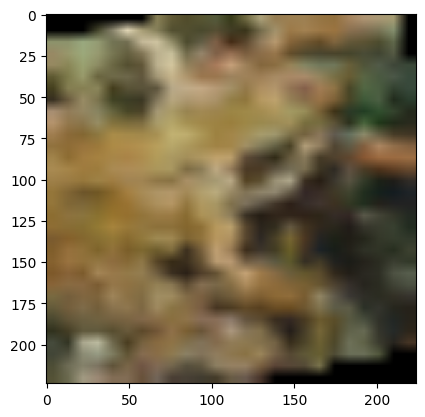

car


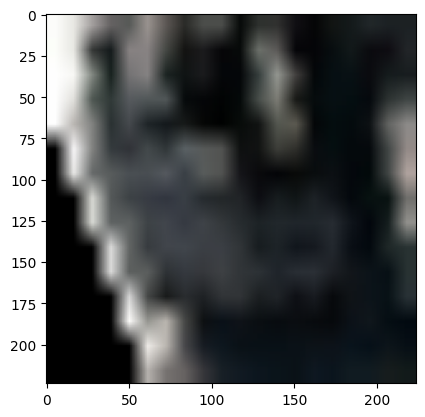

horse


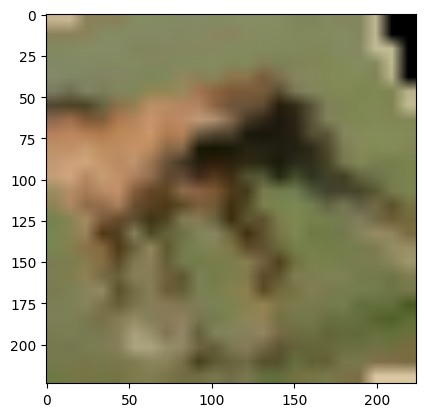

ship


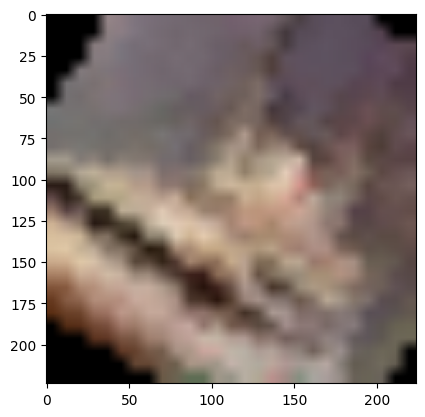

ship


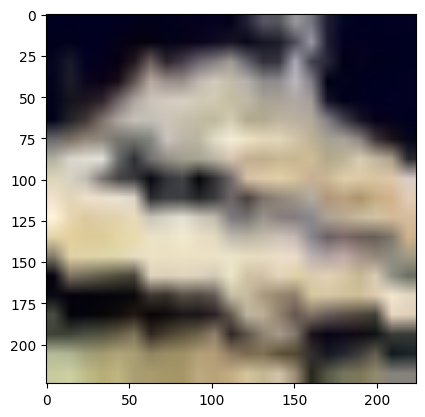

In [16]:
# Explore data
show5(trainloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [17]:
# transfer learning with smallest pretained ResNet model
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# Freeze parameters to suppress backpropagation
for param in model.parameters():
    param.requires_grad = False

num_classes = 10 # number of classes
model.fc = nn.Sequential(nn.Linear(512, 256),
                         nn.ReLU(),
                         nn.Dropout(0.6),
                         nn.Linear(256, num_classes),
                         nn.LogSoftmax(dim=1))

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [18]:
# loss function
criterion = nn.NLLLoss()

# optimizer, train only parameters of model.fc
learning_rate = 0.003
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [42]:
# training and subsequently testing per epoch 
# Use GPU if available, for MacBook Pro M1 'mps'
device = torch.device('mps')
model.to(device)

start = time.time()

epochs = 8
steps = 0
eval_every = batch_size

train_loss_list = []
test_loss_list = []
accuracy_list = []

loop_epochs = tqdm_notebook(range(epochs), desc='Epochs',
                            position=0, leave=True,
                            total=len(range(epochs)))
for epoch in loop_epochs:   
    
    training_loss = 0
    
    # progress bar
    loop_training = tqdm_notebook(enumerate(trainloader),
                                  position=0, leave=True,
                                  total=len(trainloader))
    
    for __i__, (inputs, labels) in loop_training:
        # update loop_training
        loop_training.set_description(f'Epoch [{epoch+1}/{epochs}], training')
        
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        
        # forward pass and backward pass
        logps = model(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()
        
        # update loop_training
        loop_training.set_postfix(train_loss_int = round(loss.item(), 3))      

        if steps % eval_every == 0:
            model.eval()
            test_loss = 0
            accuracy = 0
            
            # add progress bar for testing
            loop_testing = tqdm_notebook(enumerate(testloader), 
                                         position=0,
                                         leave=True,
                                         total=len(testloader))
            
            for __ii__, (inputs_val, labels_val) in loop_testing:
                # update loop_training
                loop_testing.set_description(f'Epoch [{epoch+1}/{epochs}], testing')
                
                optimizer.zero_grad()
                
                inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
                model.to(device)
            
                with torch.no_grad():
                    logps = model(inputs_val)
                    test_loss += criterion(logps, labels_val).item()
                    ps = torch.exp(logps).data
                                        
                    equals = labels_val.data == ps.max(1)[1]
                    accuracy += equals.type_as(torch.FloatTensor()).mean().item()
                
                # update loop_testing
                testing_loss_intermediate = round(criterion(logps, labels_val).item(), 3)
                accuracy_intermediate = round((equals.type_as(torch.FloatTensor()).mean()).item(), 3)
                loop_testing.set_postfix(test_loss_int=testing_loss_intermediate,
                                         acc_int=accuracy_intermediate)

            training_loss = training_loss/ len(trainloader)
            accuracy = accuracy / len(testloader)
            test_loss = test_loss / len(testloader)

            train_loss_list.append(training_loss)
            test_loss_list.append(test_loss)
            accuracy_list.append(accuracy)
            
            # update overall progress bar with accuracy,train and test loss of epoch
            loop_epochs.set_postfix(train_loss_e=training_loss,
                                    test_loss_e=test_loss,
                                    acc_e=accuracy)

time_elapsed = time.time() - start
print(f'Training time: {time_elapsed//60}m {time_elapsed%60}')

Epochs:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

Training time: 31.0m 17.282782316207886


Plot the training loss (and validation loss/accuracy, if recorded).

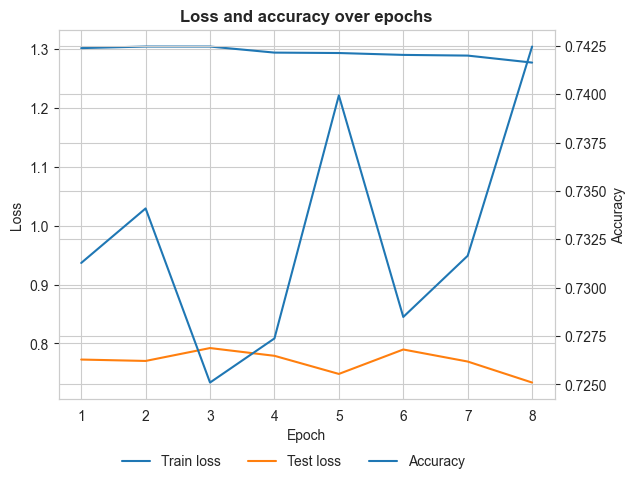

In [107]:
sns.set_style("whitegrid")

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

train_loss = ax1.plot(train_loss_list)
test_loss = ax1.plot(test_loss_list)
accucary = ax2.plot(accuracy_list)

ax1.set_xlabel('Epoch')
ax1.set_xticks(np.arange(0, 8), np.arange(8)+1)

ax1.set_ylabel('Loss')
ax2.set_ylabel('Accuracy')

fig.legend(['Train loss', 'Test loss', 'Accuracy'], 
           loc='lower center',
           bbox_to_anchor=(.492, -0.06), ncol=3, frameon=False)

ax1.set_title('Loss and accuracy over epochs', fontweight='bold')
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [43]:
## obsolete due to combined training and testing ##

## Saving your model
Using `torch.save`, save your model for future loading.

In [109]:
checkpoint = {'output_size': num_classes,
              'structure': 'resnet18',
              'model_fc' : model.fc,
              'learning_rate': learning_rate,
              'epochs': epochs,
              'class_to_idx': train_data.class_to_idx,
              'state_dict': model.state_dict(),
              'optimizer': optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint_resnet18.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does the model compare to Detectocorp's model?
* How does the model compare to the far more advanced solutions in the literature?
* What did you do to get the accuracy you achieved?    
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

Based on the previous evaluation it is recommended to build a model instead of buying from Dectocorp due to multiple reasons:

The trained model (accuracy 0.74) outperforms the model of Detectocorp (accuracy 0.70). Transfer learning was used to improve model performance, reduce training time and training data requirements. Moreover, transfer learning should result in better generalization and is quickly deployed.

However, compared to models in the literature the used model does not achieve comparable accuracy. Reasons for this could lie in:
* the preprocessing of the training data,
* the quality of the training data,
* the adjustment of hyperparameters such as learning rate or momentum,
* batch size,
* limited training respectively GPU time,
* simple model structure.

With the used model an accuracy of 0.742 was achieved through the following:
1. Training data was rotated, resized and cropped (224x224), horizontally flipped, turned into a tensor and finally normalized.
2. ResNet18 was chosen as a simple image recognition algorithm and used as overall model architecture. The weights of a pretrained ResNet18 model were used for training with the exception of the fully connected layer.
3. The fully connected layer was adjusted to ouput 10 classes.
4. Only the subsituted fully connected layer was trained, while the remaining weights of the pretrained model were frozen. A batch size of 224 samples and a learning rate of 0.03 was used.
5. Intermediate training, testing loss and accuracy were displayed in progress bars and means were logged after one epoch.
6. Losses and accuracy were plotted over training epochs to rule out over or underfitting.

The necessity of further improving accuracy depends largely on the use of the model. Since no lives depend on whether an image is misclassified, results could be sufficient for some applications. Generally, hyperparameters such as learning rate, momentum or batch size could be experimented with using grid search, random search, or Bayesian optimization. Considering the learning rate scheduling or adaptive learning rate methods could be applied. Since ResNet18 is a comparatively small model, one could also apply ensembling and combine multiple ResNet18 models with different initializations and hyperparameters. Moreover, it is possible to chose a different overall model architecture as indicated in the literature. Ultimately, more training data could potentially result in better model performance and in parallel contribute to better generalization of the model.

## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).